In [1]:
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
import imageio
from ast import literal_eval
import os

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer,Dense,Flatten
from tensorflow.keras.optimizers import Adam
from IPython.display import Image
from ringbell import RingBell
a = RingBell(
    sample = "ding-47489.mp3",
    minimum_execution_time = 0,
    verbose = True
)

In [2]:
# -*- coding: utf-8 -*-


class Position:  #Correspond à une case du labyrinthe

    def __init__(self, north, east, south, west):
        self.north = north
        self.east = east
        self.south = south
        self.west = west
        self.walls = [north, east, south, west]
        self.exit = False
        self.player = False

    def get_walls(self):
        return self.walls

    def set_walls(self, new_walls):
        self.walls = new_walls

    def actualize_walls(self):
        self.set_walls([self.north, self.east, self.south, self.west])

    def set_north(self, north):
        self.north = north
        self.actualize_walls()

    def set_east(self, east):
        self.east = east
        self.actualize_walls()

    def set_south(self, south):
        self.south = south
        self.actualize_walls()

    def set_west(self, west):
        self.west = west
        self.actualize_walls()

    def place_player(self):
        self.player = True

    def remove_player(self):
        self.player = False

    def set_exit(self):
        self.exit = True

    def remove_exit(self):
        self.exit = False


class Maze:

    def __init__(self, size=10):
        if size < 3:
            print("taille trop petite")
            raise ValueError
        else:
            self.size = size
            self.all_positions = [[Position(j == size-1,
                                            i == size - 1,
                                            j == 0,
                                            i == 0)
                                   for i in range(size)] for j in range(size)]
            self.exit = random_pos(size)
            self.player = random_pos(size)

    def randomize(self):  #randomise la position de la sortie et du joueur
        self.remove_exit()
        self.remove_player()
        x = int(random.random()*self.size)
        y = int(random.random()*self.size)
        self.set_exit(x, y)
        xj = x
        yj = y
        while xj == x and yj == y:
            xj = int(random.random()*self.size)
            yj = int(random.random()*self.size)
        self.place_player(xj, yj)
        
        for i in range(self.size):
            for j in range(self.size):
                if i != self.size -1:
                    self.changeWall(i, j, 2, int(random.random()*2))
                if j != self.size - 1:
                    self.changeWall(i, j, 1, int(random.random()*2))

    def get_position(self, i, j):
        return self.all_positions[self.size -1 -i][j]

    def __str__(self):
        maze_str = " "
        # first line
        for i in range(self.size):
            maze_str += "__"
        maze_str += "\n"
        for i in range(self.size):
            for j in range(self.size):
                position = self.get_position(i, j)
                walls = position.get_walls()
                if walls[3]:
                    maze_str += "|"
                    if walls[2]:
                        if position.exit:
                            maze_str += "+"
                        elif position.player:
                            maze_str += "·"
                        else:
                            maze_str += "_"
                    else:
                        if position.exit:
                            maze_str += "+"
                        elif position.player:
                            maze_str += "·"
                        else:
                            maze_str += " "
                elif walls[2]:
                    if position.exit:
                        maze_str += "+"
                    elif position.player:
                        maze_str += "·"
                    else:
                        maze_str += "__"
                else:
                    if position.exit:
                        maze_str += " "
                        maze_str += "+"
                    elif position.player:
                        maze_str += " "
                        maze_str += "·"
                    else:
                        maze_str += "  "
                if j == self.size - 1:
                    if i == self.size - 1:
                        maze_str += "|\n"
                    else:
                        maze_str += "|\n"
        return maze_str

    def plot(self,title = "", filename = None,agent = None):
        
        n = self.size
        plt.figure(figsize = (4, 4))
        plt.title(title)
        plt.axis('off')
        plt.plot([0,0,n,n,0],[0,n,n,0,0],color = 'black',linewidth=7.0)
      

        for i in range(self.size):
            plt.plot([i,i],[0,n],color = 'black',alpha = 0.2)
            plt.plot([0,n],[i,i],color = 'black',alpha = 0.2)

        for i in range(n):
            for j in range(n):
                if self.get_position(j, i).east:
                    plt.plot([i+1,i+1],[self.size-j,self.size-j-1],linewidth=7.0,color = 'black')
                if self.get_position(j, i).south:
                    plt.plot([i,i+1],[self.size-j-1,self.size-j-1],linewidth=7.0,color = 'black')
        
        try:
            (i,j) = self.player
            (i_e,j_e) = self.exit
            if j!=j_e or i!= i_e:
                j += 0.5
                i += 0.5
                plt.scatter(i,j,linewidths = 5,color = 'red')

                (i,j) = self.exit
                j += 0.5
                i += 0.5
                plt.scatter(i,j,linewidths = 10,color = 'green',marker = '+')
            else:
                j += 0.5
                i += 0.5
                plt.scatter(i,j,linewidths = 5,color = 'yellow')
                plt.scatter(i,sj,linewidths = 10,color = 'yellow',marker = '+')
        except:
            pass
        
        
        if agent is not None:   #Cette partie permet d'afficher la politique moyenne de l'agent passé en argument
            directions = [np.array((-1,0)),np.array((0,1)),np.array((1,0)),np.array((0,-1))]

            for i in range(n):
                for j in range(n):
                    probas = np.array(agent(np.array([[i,j]]))[1])[0]
                    direc_moy = np.zeros(2)
                    for a in range(4):
                        direc_moy += directions[a]*probas[a]/2
                    plt.arrow(x = i+0.5-direc_moy[0]/2,y=j+0.5-direc_moy[1],dx  = direc_moy[0],dy = direc_moy[1],color = 'black',width = 0.05)
        
        
        if filename is not None: #Sauvegarde eventuelle de l'image
            plt.savefig(filename)
        else:
            plt.show()
        plt.close()



    def changeWall(self, i, j, wallNumber, wallValue):
        position = self.get_position(i, j)
        if wallNumber == 0:
            position.set_north(wallValue)
            if i != 0:
                self.get_position(i - 1, j).set_south(wallValue)
        elif wallNumber == 1:
            position.set_east(wallValue)
            if j != self.size - 1:
                self.get_position(i, j + 1).set_west(wallValue)
        elif wallNumber == 2:
            position.set_south(wallValue)
            if i != self.size - 1:
                self.get_position(i + 1, j).set_north(wallValue)
        elif wallNumber == 3:
            position.set_west(wallValue)
            if j != 0:
                self.get_position(i, j - 1).set_east(wallValue)

    def set_exit(self, i, j):
        if self.exit is None:
            self.get_position(i, j).set_exit()
            self.exit = (i, j)

    def remove_exit(self):
        if self.exit is not None:
            self.get_position(*self.exit).remove_exit()
            self.exit = None

    def place_player(self, i, j):
        if self.player is None:
            self.get_position(i, j).place_player()
            self.player = (i, j)

    def remove_player(self):
        if self.player is not None:
            self.get_position(*self.player).remove_player()
            self.player = None

    def move_player(self, new_i = -1, new_j = -1, direction = (0,0), force = False):  #Fait bouger de force le joueur en (new_i,new_j) ou tente de le bouger selon les règles du labyrinthe, dans la direction donnée
        if force:
            self.remove_player()
            self.place_player(new_i, new_j)
            self.positions_explored = []
            return True
        else:
            (i,j) = self.player
            new_i = i + direction[0]
            new_j = j  + direction[1]
            
            flag = False
          
            walls = self.get_position(self.size -1 -j,i).get_walls()
            if new_i == i + 1:
                if not walls[1]:
                    flag = True
            elif new_i == i - 1:
                if not walls[3]:
                    flag = True
            elif new_j == j + 1:
                if not walls[0]:
                    flag = True
            elif new_j == j - 1:
                if not walls[2]:
                    flag = True
            if flag:   #si le mouvement est possible
                self.remove_player()
                self.place_player(new_i, new_j)
                return True
            else:
                return False

            
def random_pos(n): #Position aléatoire dans le labyrinth
    return (random.randint(n),random.randint(n))


class Environment:

    def __init__(self, maze):
        self.maze = maze
        self.step_count = 0  #Nombre de mouvements du joueur initialisé à 0
        self.directions = [(-1,0),(0,1),(1,0),(0,-1)]

    def reset(self):
        self.step_count = 0
        self.maze.player = random_pos(self.maze.size)
        while self.maze.player == self.maze.exit:
            self.maze.player = random_pos(self.maze.size)
    
    def get_state(self):
        pos = self.maze.player
        return(np.array(pos).reshape(1,2))
        
    def step(self,action,rewarder,max_step):  
        
        self.step_count +=1
        self.maze.move_player(direction = self.directions[action]) #Tentative de déplacement selon l'action 
        
        state = self.get_state()
        reward = float(rewarder(state))  #Récompense fournie par la fonction de récompense

        if (self.maze.player == self.maze.exit): #le joueur atteint la sortie
            
            self.reset()
            playing = False
            return reward,playing,state
        
        if self.step_count >=max_step: #maximum de max_step déplacements pour arriver à la sortie

            self.reset()
            playing = False
            return reward,playing,state  #Rajout d'une grosse pénalité, pour favoriser le fait
        
        playing = True
        return reward,playing,state

    
def random_maze(n = 10):   #Création d'un labyrinthe aléatoire, par suppresion succesives de murs jusqu'à ce que toutes les cases soient connectées
    maze = Maze(size = n)
    
    for i in range(n):
        for j in range(n):
            for a in range(4):
                maze.changeWall(i,j,a,1)



    deplacements = [(-1,0),(0,1),(1,0),(0,-1)]
    A = [[i+n*j for i in range(n)] for j in range(n)]  #Classe d'équivalence entre les cellules: 2 cellules ayant la même classe possedent un chemin allant de l'une a l'autre
    for i in range(n**2-1):  #n*n -1 murs a briser pour tout relier
        (x,y) = (random.randint(0,n),random.randint(0,n)) #selection d'une cellule aleatoire
        a = random.randint(0,4) #mur a ouvrir
        x2 = x + deplacements[a][0]
        y2 = y + deplacements[a][1]
        while not(0<=x2<=n-1 and 0 <= y2 <= n-1 and A[x][y] != A[x2][y2] ):   #Recheche de deux cellules adjacentes non reliées par un chemin
            (x,y) = (random.randint(0,n), random.randint(0,n)) #selection d'une cellule aleatoire
            a = random.randint(0,4) #mur a ouvrir
            x2 = x + deplacements[a][0]
            y2 = y + deplacements[a][1]        
        maze.changeWall(x,y,a,0)
        
        #Mise à jour de la classe d'équivalence
        id_a_changer = A[x2][y2]
        id_remplacement = A[x][y]
        for k in range(n):
            for l in range(n):
                if A[k][l] == id_a_changer:
                    A[k][l] = id_remplacement
    
    #Sortie et joueur à une position aléatoire
    x = random.randint(n)
    y = random.randint(n)
    maze.set_exit(x, y)
    xj = x
    yj = y
    while xj == x and yj == y:
        xj = random.randint(n)
        yj = random.randint(n)
    maze.place_player(xj, yj)
    
    return maze

In [3]:
def make_gif(maze,lst_pos,lst_actions = None,path = "mygif"):  #Création de gif de la trajectoire specifiée par les pos et actions
    n = len(lst_pos)
    filenames = []
    for i in range(n):
        maze.remove_player()
        maze.place_player(lst_pos[i][0,0],lst_pos[i][0,1])
        filename = f'GIF//{i}.png'
        if lst_actions is None:
            maze.plot(filename = filename)
        else:
            maze.plot(filename = filename,title = "Prochain déplacement : {}".format(["◄","▲","►","▼"][lst_actions[i]]))
        filenames.append(filename)

    maze.remove_player()
    maze.remove_player()
    filename = f'GIF//{i+1}.png'
    maze.plot(filename = filename)
    filenames.append(filename)
    
    #Enregistrement du gif à l'emplacement voulu
    with imageio.get_writer('{}.gif'.format(path), mode='I',duration = 1) as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)

In [4]:
class Agent(tf.keras.Model):
    def __init__(self,n_hidden):
        super().__init__()
        self.shared_1 = Dense(n_hidden,activation = 'relu')
        self.actor = Dense(4)
        
        
    def call(self,obs):
        x = self.shared_1(obs)
        possible_actions =  self.actor(x)
    
        proba_actions = tf.nn.softmax(possible_actions)  #la probabilité de choisir l'action i est proba_actions[i]
        action_chosed = np.random.choice([0,1,2,3],p = np.array(proba_actions).reshape(4))
        return(action_chosed,proba_actions)       

        
        

class Rewarder(tf.keras.Model):
    def __init__(self,n_hidden,n,mean,sd):
        super().__init__()
        self.shared_1 = Dense(n_hidden,activation = 'relu')
        self.reward = Dense(1)
        self.sd_visee = sd
        self.mean_visee = mean
        
        self.sd_actuelle = 1
        self.mean_actuelle = 0
    
        self.update(n)
    
    def update(self,n):  #Permet de mettre à jour les paramètres pour normaliser la sortie du rewarder
        A = np.array([[self.call(np.array([[i,j]]),normalize = False) for i in range(n)] for j in range(n)]).reshape(n**2)
        self.mean_actuelle = np.mean(A)
        self.sd_actuelle = np.std(A)
        
    def call(self,obs,normalize = True):
        if not normalize:
            x = self.shared_1(obs)
            return self.reward(x)
        else:
            x = self.shared_1(obs)
            return (self.reward(x)-self.mean_actuelle)* self.sd_visee/self.sd_actuelle + self.mean_visee
    
    def plot(self,n):   #Visualisation de la recompense selon les cases
        plt.imshow([[float(rewarder(np.array([[i,n-1-j]])))for i in range(n)]for j in range(n)])
        plt.colorbar()
        plt.show()

In [5]:
def discounted_reward(reward_lst,gamma): #Calcule la récompense discounté par un facteur gamma, plus une action est loin, moins la récompense associée compte
    lst_total_reward = []
    total_reward = 0
    for r in reward_lst[::-1]:
        total_reward *= gamma
        total_reward += r
        lst_total_reward.append(total_reward)
    return np.array(lst_total_reward[::-1])

def agent_loss(action_probs,rewards):
    d_reward = discounted_reward(rewards,gamma = 0.9)
    action_log_probs = tf.math.log(action_probs)
    loss = - tf.math.reduce_sum(action_log_probs*d_reward)
    return loss

def one_trajectory(env,agent,rewarder,max_step = 5):  #effectue une trajectoire complète 
    env.reset()
    
    lst_states = []  #Etats parcourus
    lst_actions = []  #Actions effectuées
    lst_prob_selection = []  #Probabilités d'avoir effectué l'action
    lst_rewards = []  #Récompenses obtenues
    playing = True  #On joue jusqu'à atteindre la sortie ou à arriver à cours de mouvements
    
    state = env.get_state()
    lst_states.append(state)
    while playing:
        
        action,prob = agent(state)  #Récupération d'une action et de sa probabilité par application de la politique de l'agent
        reward,playing,state = env.step(action,rewarder,max_step)  #On fait jouer l'action determinée
        
        lst_states.append(state)
        lst_actions.append(action)
        lst_rewards.append(reward)

        lst_prob_selection.append(prob[0][action])
    
    return lst_states,lst_actions,lst_rewards,lst_prob_selection


In [6]:
def update_policy(env,agent,rewarder,n_etapes,max_step,plot = False):
    
    scores = []
    lst_grads = []

    for etape in range(n_etapes):
        
        
        with tf.GradientTape() as tape:

            lst_states,lst_actions,lst_rewards,lst_prob_selection  =  one_trajectory(env,agent,rewarder,max_step)
            loss = agent_loss(lst_prob_selection, lst_rewards)
        
        grads = tape.gradient(loss, agent.trainable_variables)
        scores.append(len(lst_rewards))
        
        
        lst_grads.append(grads)           
        
        if etape % 50 == 0: # On optimise toutes les 50 trajectoires parcourues
            grads_total = lst_grads[0]
            for grads in lst_grads:
                for (i,grad) in enumerate(grads):
                    grads_total[i] += grads[i]
            
            optimizer.apply_gradients(zip(grads_total, agent.trainable_variables))
            lst_grads = []
            
        if plot and etape % 100 == 0:  #1ffichage eventuel de la performance de l'agent sur les 100 dernières iterations
            print("Episode  {}  Score  {}".format(etape, np.mean(scores[-100:])))

    

In [7]:
class Trajectory:

    def __init__(self, tab = []):
        self.trajectory = tab


class Preference:

    def __init__(self, trajectory1, trajectory2, mu1, mu2):
        self.trajectory1 = trajectory1
        self.trajectory2 = trajectory2
        self.mu1 = mu1
        self.mu2 = mu2

    def compute_probability(self, function):
        r1 = sum([function(k) for k in self.trajectory1.trajectory[1:]])
        r2 = sum([function(k) for k in self.trajectory2.trajectory[1:]])
        return (tf.exp(r1))/(tf.exp(r1) + tf.exp(r2))

    def compute_loss(self, function):

        proba = self.compute_probability(function)
        return - self.mu1*tf.math.log(proba) - self.mu2*tf.math.log(1-proba)



In [8]:
def make_comparisons(env,agent,rewarder,n_comparisons,max_step):
    Lst_prefs = []
    for i in range(n_comparisons):
        
        #Simulation et enregistrement sous GIF de deux trajectoires
        traj1 = one_trajectory(env,agent,rewarder,max_step)
        traj2 = one_trajectory(env,agent,rewarder,max_step)

        make_gif(maze,traj1[0][:-1],traj1[1],path = "trajectoire 1")
        make_gif(maze,traj2[0][:-1],traj2[1],path = "trajectoire 2")

        
        #Demande à l'utilisateur son choix
        print("first trajectory :")
        display(Image(data=open("trajectoire 1.gif",'rb').read(), format='png'))
        print("second trajectory :")
        display(Image(data=open("trajectoire 2.gif",'rb').read(), format='png'))
        print("which one do you prefer ? (1 or 2)")
        print("If you consider that both segments are equally preferable, type 3.")
        print("If you consider that the segments are not comparable, type 0.")
        
        try:
            choice = int(input("Please type 0, 1, 2 or 3 : "))
        except:
            choice = 4
        
        if choice == 1:
            new_pref = Preference(Trajectory(traj1[0]), Trajectory(traj2[0]), 1, 0)
        elif choice == 2:
            new_pref = Preference(Trajectory(traj1[0]), Trajectory(traj2[0]), 0, 1)
        elif choice == 3:
            new_pref = Preference(Trajectory(traj1[0]), Trajectory(traj2[0]), 1/2, 1/2)
        else:
            pass
        
        try:
            Lst_prefs.append(new_pref)
        except:
            pass
    return Lst_prefs

In [9]:
def update_rewarder(rewarder,lst_prefs):
    
        
    for pref in lst_prefs:
        with tf.GradientTape() as tape:
            loss = pref.compute_loss(rewarder)
        grads = tape.gradient(loss, rewarder.trainable_variables)
        optimizer_reward.apply_gradients(zip(grads, rewarder.trainable_variables))

    rewarder.update(n)#Laisser la moyenne et variance voulue

In [10]:
def evalue_agent(maze,agent,max_step,n_repet): #Calcule le nombre d'étapes moyens pour atteindre la sortie
    
    res = 0
    
    for i in range(n_repet):
        res += len(one_trajectory(env,agent,lambda s:0,max_step)[0])
    
    return res/n_repet

In [11]:
n = 3

maze = random_maze(n)
#maze = Maze(size = n)
maze.exit = (0,2)
env = Environment(maze)


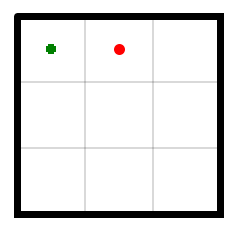

In [12]:
maze.plot()


In [13]:
agent = Agent(100)
rewarder = Rewarder(100,n,mean = -2,sd = 2)

#Pour comparer avec  le cas classique, sans appel à l'utilisateurn, on considère une fonction de récompense choisie à l'avance
# et on utilise un autre agent
agent2 = Agent(100)
rewarder2 = lambda s :  -np.sum(np.abs(np.array(maze.exit) - s.reshape((2))))  - 2

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.002)
optimizer_reward = tf.keras.optimizers.Adam(learning_rate = 0.002)

In [14]:
n_iters = 5 #Nombre d'itérations globale de la boucle (Optimisation politique/ Comparaison trajectoires/ Optimisation fonction de récompense)
n_iters_policy = 1000 #Nombre d'itérations pour optimiser la politique, par tour
n_comparisons = 5 #Nombre de couples à comparer par tour

max_step_policy = 6*n  #Nombre d'actions maximal lors de l'optimisation de la politique
max_step_comparison = 1  #Nombre d'actions maximal lors de la comparaison de trajectoires
max_step_evalue = 100  #Nombre d'actions maximal lors de l'évaluation de la performance

n_repet_evalue = 1000 #Nombre de simulations pour obtenir la performance

In [15]:
score_dnn = []
score_classic = []


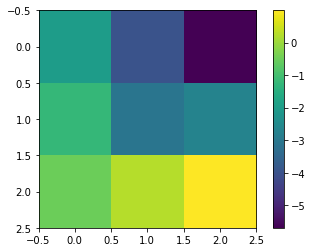

Iteration 0


first trajectory :


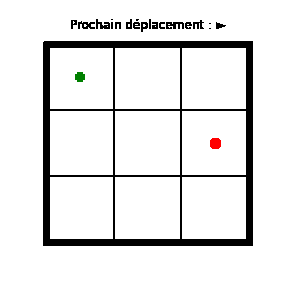

second trajectory :


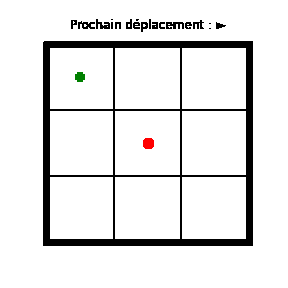

which one do you prefer ? (1 or 2)
If you consider that both segments are equally preferable, type 3.
If you consider that the segments are not comparable, type 0.
Please type 0, 1, 2 or 3 : 3
first trajectory :


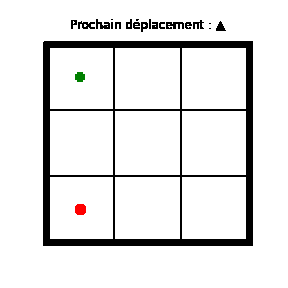

second trajectory :


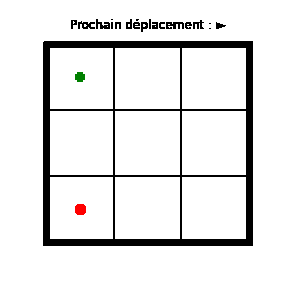

which one do you prefer ? (1 or 2)
If you consider that both segments are equally preferable, type 3.
If you consider that the segments are not comparable, type 0.
Please type 0, 1, 2 or 3 : 1
first trajectory :


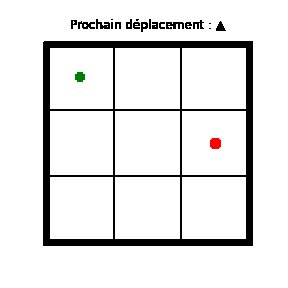

second trajectory :


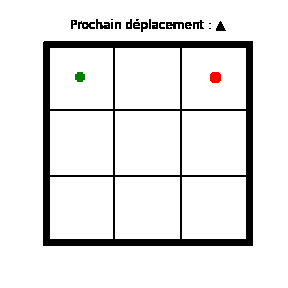

which one do you prefer ? (1 or 2)
If you consider that both segments are equally preferable, type 3.
If you consider that the segments are not comparable, type 0.
Please type 0, 1, 2 or 3 : 1
first trajectory :


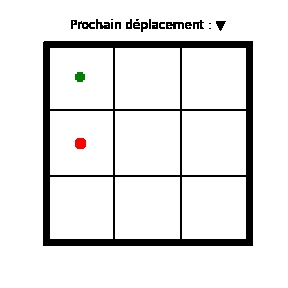

second trajectory :


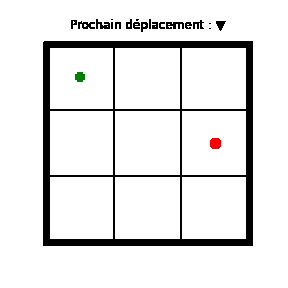

which one do you prefer ? (1 or 2)
If you consider that both segments are equally preferable, type 3.
If you consider that the segments are not comparable, type 0.
Please type 0, 1, 2 or 3 : 3
first trajectory :


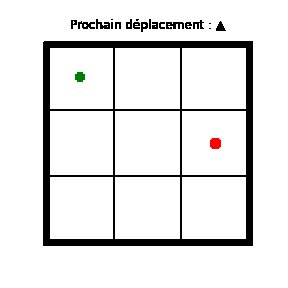

second trajectory :


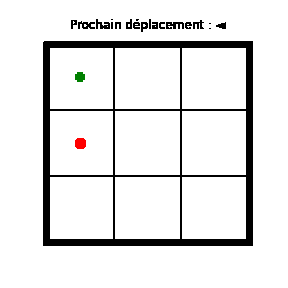

which one do you prefer ? (1 or 2)
If you consider that both segments are equally preferable, type 3.
If you consider that the segments are not comparable, type 0.
Please type 0, 1, 2 or 3 : 1
score actuel:  18.059
Iteration 1


first trajectory :


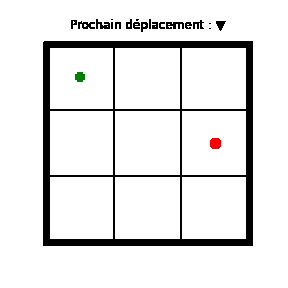

second trajectory :


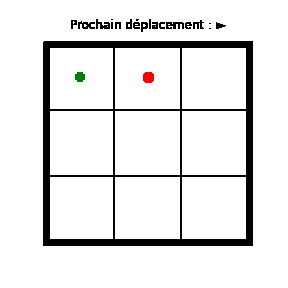

which one do you prefer ? (1 or 2)
If you consider that both segments are equally preferable, type 3.
If you consider that the segments are not comparable, type 0.


In [ ]:
rewarder.plot(n)
for i in range(n_iters):
    print("Iteration {}".format(i))
    
    a()   #Un bruit pour attirer l'attention de l'humain pour faire ses comparaisons
    #maze.plot(agent = agent)
    lst_prefs = make_comparisons(env,agent,rewarder,n_comparisons,max_step_comparison)
    update_rewarder(rewarder,lst_prefs)
    #rewarder.plot(n)
    update_policy(env,agent,rewarder,n_iters_policy,max_step_policy,plot = False)
    
    #lst_prefs = make_comparisons(env,agent,rewarder,n_comparisons,max_step_comparison)
    #update_rewarder(rewarder,lst_prefs)
    
    score_dnn.append(evalue_agent(maze,agent,max_step_evalue,n_repet_evalue))
    print("score actuel: ",score_dnn[-1])

In [ ]:
for i in range(n_iters):
    print("Iteration {}".format(i))
    update_policy(env,agent2,rewarder2,n_iters_policy,max_step_policy,plot = False)
    score_classic.append(evalue_agent(maze,agent2,max_step_evalue,n_repet_evalue))

In [ ]:
#Score pour un agent choisisant chaque direction au hasard
score_random = evalue_agent(maze,lambda s: (random.randint(0,4),np.array([[0.25]*4])),max_step_evalue,n_repet_evalue*10)

#Score pour un agent faisant les choix optimaux, determiné de visu selon le labyrinth
score_optimal = 2.25

In [ ]:
plt.plot(score_dnn)
plt.plot(score_classic,color = "yellow")
plt.axhline(score_random,color = 'r')
plt.axhline(score_optimal,color = "b")
plt.legend(["Agent avec retour humain","Agent avec fonction de récompense","Agent aléatoire","Agent optimal"])

In [ ]:
maze.plot(agent = agent2)

In [ ]:
maze.plot(agent = agent)

In [ ]:
make_gif(one_trajectory(env,agent,rewarder,max_step = 10)[0],path = "trajectoire_sans_murs_retour_humain")
make_gif(one_trajectory(env,agent2,rewarder,max_step = 10)[0],path = "trajectoire_sans_murs_fonction_recompense_deterministe")
make_gif(one_trajectory(env,lambda s: (random.randint(0,4),np.array([[0.25]*4])),rewarder,max_step = 10)[0],path = "trajectoire_sans_murs_aleatoire")